# Запуск обученной модели на тестовых данных и сравнение с zero-shot-classification
В этом ноутбуке:
* Производится простой EDA
* Запускается `zero-shot-classification` и `fine-tuned RoBERTa` на одном наборе тестовых данных
* Сравниваются полученные результаты

Сравнение производится следующим образом:
* Строится Precision-Recall кривая
* Находится оптимальное значение для порога классификации (лучший порог по `F1-score`)
* Оцениваются `Accuracy` и `F1-score`

Дополнительно:
* Обе PR-кривые рисуются на одном графике для наглядности
* Рисуется TPR-FPR-кривая для обоих методов (получаем наглядную оценку для AUC-score)

## Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import yaml
from matplotlib import pyplot as plt
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

from data import generate_datasets, read_data
from model import RoBERTaClassification
from utils import get_project_root, get_report

%matplotlib inline

In [4]:
# Load configs
PROJECT_ROOT = get_project_root()
with open(PROJECT_ROOT / 'config.yml') as fin:
    params = yaml.load(fin, Loader=yaml.FullLoader)

## A little bit of EDA
Summary:

* Имеется дизбаланс классов: 29753 / 2209 (0 - 93%/ 1 - 7%)
* Длина твитов с `hate speech` и без него имеют одинаковое распределение

In [5]:
# Load splitted dataset
train_data = pd.read_csv(PROJECT_ROOT / Path(params["data"]["path_to_data"]) / params["data"]["train_filename"])
valid_data = pd.read_csv(PROJECT_ROOT / Path(params["data"]["path_to_data"]) / params["data"]["validation_filename"])
test_data = pd.read_csv(PROJECT_ROOT / Path(params["data"]["path_to_data"]) / params["data"]["test_filename"])

# Basic information
data = pd.concat([train_data, valid_data, test_data])

print(f'Shapes (train/val/test): {train_data.shape[0]}/{valid_data.shape[0]}/{test_data.shape[0]}')
print('Shape of total dataset:', data.shape)

Shapes (train/val/test): 19177/6393/6392
Shape of total dataset: (31962, 2)


Classes balance:
0 class: 29720 samples (0.93)
1 class: 2242  samples (0.07)

Length information:


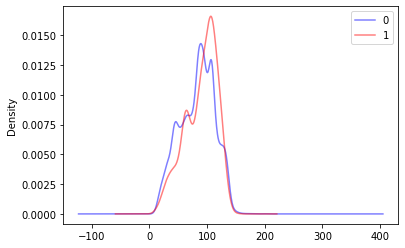

In [17]:
neg_class_count = data['label'].tolist().count(0)
pos_class_count = data['label'].tolist().count(1)
total_count = data.shape[0]

print('Classes balance:')
print(f'0 class: {neg_class_count} samples ({round(neg_class_count/total_count, 2)})')
print(f'1 class: {pos_class_count}  samples ({round(pos_class_count/total_count, 2)})\n')

print('Length information:')
data.query('label == 0')['tweet'].apply(len).plot.kde(color='b', alpha=0.5, label='0')
data.query('label == 1')['tweet'].apply(len).plot.kde(color='r', alpha=0.5, label='1')

plt.legend()
plt.show()

## Zero-shot-classification running on test dataset
* Загружаем модель из transformers от 🤗
* Запускаем модель на тестовых данных

In [5]:
# Load model for zero-shot-classification
from transformers import pipeline
classifier = pipeline('zero-shot-classification')

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m

In [7]:
sequences = test_data['tweet'].values.tolist()
labels = ['sexism', 'racism', 'hate speech']
batch_size = 1
zero_shot_predictions = []

for idx in tqdm(range(len(sequences))):
    res = classifier(sequences[idx], labels, multi_label=True)

    output = {}
    for label, score in zip(res['labels'], res['scores']):
        output[label] = score
    zero_shot_predictions.append(output)

with open(
        PROJECT_ROOT / params['data']['path_to_data'] /
        params['data']['path_to_test_zero_shot'], 'w') as fout:
    json.dump(zero_shot_predictions, fout)

## Fine-tuning RoBERTa running on test dataset
* Загружаем обученную модель
* Запускаем модель на тех же тестовых данных, что и zero-shot

In [2]:
model = RoBERTaClassification.load_from_checkpoint(
    PROJECT_ROOT / params['model']['model_path'])
model.eval()

RoBERTaClassification(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

### Fine-tuned lightning model prediction

In [3]:
from scipy.special import softmax
new_model_predictions = []
new_model_probabilities = []

for text in tqdm(test_data.tweet):
    res = model(**model.encode(text)).tolist()[0]
    new_model_predictions.append(res)
    new_model_probabilities.append(softmax(res))

np.savetxt(X=new_model_probabilities,
           fname=PROJECT_ROOT / params['data']['path_to_data'] /
           params['data']['path_to_test_finetuned'])

# Анализ результатов (сравнение метрик)
В качестве метрики для оценки в задании было предложено использовать `Accuracy`, что мы и оценим. Однако я хочу оценить также и `F1-score` из-за того, что в данных заметен значительный диcбаланс и метрика `Accuracy` будет нам "льстить".

| Negative (0)  | Positive (1)  |
| ------------- |:-------------:|
| 29753         | 2209          |
| 0.93          | 0.07          |


Порог для treshold будем выбирать как тот, при котором `F1-score` будет наилучшим. И при данном пороге посмотрим, какие будут метрики: `Accuracy` и `F1-score`.

In [6]:
# Correct labels for our test dataset
true_predictions = test_data['label'].values

### Analysis of zero-shot-predictions

Best Threshold: 0.4999 with F-Score: 0.4274
Recall: 0.5168, Precision: 0.3644

(With best threshold) Accuracy: 0.90, F1: 0.43


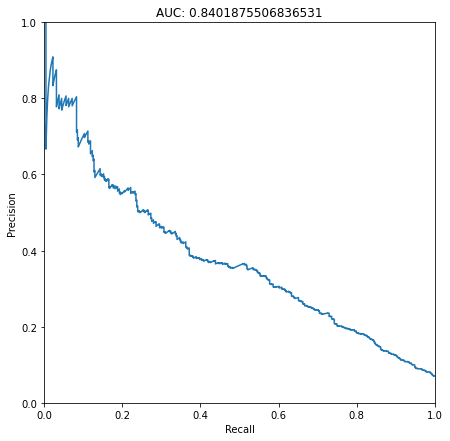

In [7]:
with open(PROJECT_ROOT / params['data']['path_to_data'] /
          params['data']['path_to_test_zero_shot']) as fin:
    non_finetuned_data = json.load(fin)

non_finetuned_predictions = [max(pred.values()) for pred in non_finetuned_data]
non_finetuned_rec, non_finetuned_pr = get_report(true_predictions,
                                                 non_finetuned_predictions)

### Analysis of fine-tuned model predictions

Best Threshold: 0.2496 with F-Score: 0.5666
Recall: 0.5951, Precision: 0.5407

(With best threshold) Accuracy: 0.94, F1: 0.57


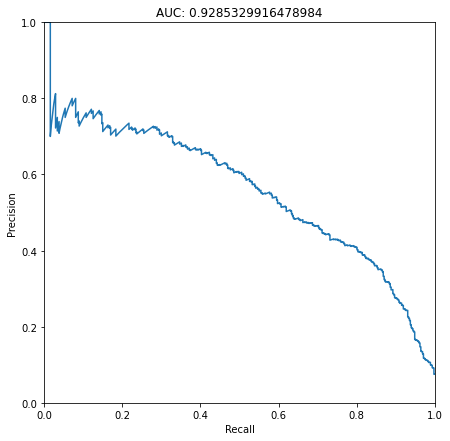

In [8]:
finetuned_probs = np.loadtxt(fname=PROJECT_ROOT /
                             params['data']['path_to_data'] /
                             params['data']['path_to_test_finetuned'])
finetuned_probs = finetuned_probs[:, 1]
finetuned_rec, finetuned_pr = get_report(true_predictions, finetuned_probs)

### On the same plot (Precision-Recall)
График дообученной модель больше изогнут вверх, что хорошо для PR-кривой. Это означает, что обученная модель лучше предсказывает нужный класс.

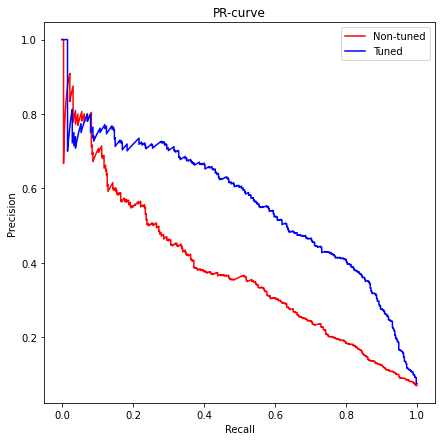

In [9]:
plt.figure(figsize=(7, 7))

plt.plot(non_finetuned_rec, non_finetuned_pr, c='r', label='Non-tuned')
plt.plot(finetuned_rec, finetuned_pr, c='b', label='Tuned')

plt.title('PR-curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.savefig('../img/pr_curve.png')
plt.show()

### FPR-TPR plot

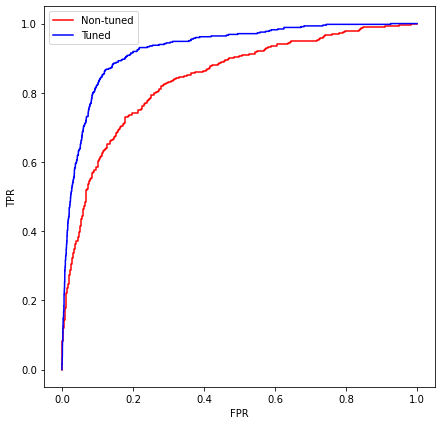

In [10]:
from sklearn.metrics import roc_curve
finetuned_fpr, finetuned_tpr, _ = roc_curve(true_predictions, finetuned_probs)
non_finetuned_fpr, non_finetuned_tpr, _ = roc_curve(true_predictions,
                                                    non_finetuned_predictions)

plt.figure(figsize=(7, 7))

plt.plot(non_finetuned_fpr, non_finetuned_tpr, c='r', label='Non-tuned')
plt.plot(finetuned_fpr, finetuned_tpr, c='b', label='Tuned')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

## Conclusion
Как видно из сравнения метрик - `zero-shot-classification` показывает более низкое качество, нежели дообученная модель.


* `zero-shot-classification`: Accuracy: 0.90, F1: 0.43 (threshold: 0.5)
* `fine-tuned`: Accuracy: 0.94, F1: 0.57 (threshold: 0.2496)

Модель обучалась на CPU, что не позволило произвести много эпох. Однако при использовании GPU качество могло еще подняться.